# Sensor Directed Sampling

**Note:** _At the moment, the SDS only supports 2 components. Please select 2 PCs when designing._

For the widgets to load properly, kindly upload it to google colab at [https://colab.research.google.com/](https://colab.research.google.com/)

In [1]:
# @title Run this Cell and then wait for the upload button to reset.

print("setting up environment")
!pip install -q pyDOE3 pykrige pysal
!rm -R sample_data

print("\nimporting libraries")

import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.covariance import EllipticEnvelope

from scipy.stats import trim_mean, trimboth, chi2
from scipy.spatial import KDTree
from scipy.spatial import distance, distance_matrix
from scipy.spatial.distance import mahalanobis

from shapely.geometry import Point
from pyDOE3 import ccdesign
from pykrige.ok import OrdinaryKriging
import pysal.lib
from esda.moran import Moran, Moran_BV_matrix
from libpysal.weights import DistanceBand, KNN

import random
from tqdm.auto import tqdm
from itertools import combinations
from functools import lru_cache
import itertools

import ipywidgets as widgets
from IPython.display import display, clear_output
from google.colab import files

random.seed(42)

print("\nupload data file here; expecting excel")
# Upload the sensor data
# Creating a file upload widget
uploader = widgets.FileUpload(
    accept='',  # Accept all file types
    multiple=False  # Allow only single file to be uploaded
)
# Function to save the uploaded file
def on_upload_change(change):
    if not uploader.value:
        print("No file uploaded.")
        return

    uploaded_file = next(iter(uploader.value))
    content = uploader.value[uploaded_file]['content']
    with open(f"/content/{uploaded_file}", "wb") as f:
        f.write(content)
    print(f"File '{uploaded_file}' has been uploaded and saved.")

# Link the function to the uploader
uploader.observe(on_upload_change, names='value')

# Display the uploader widget
display(uploader)

print("\nupload additional data file here; expecting excel or csv")
# Upload the sensor data
# Creating a file upload widget
uploader2 = widgets.FileUpload(
    accept='',  # Accept all file types
    multiple=False  # Allow only single file to be uploaded
)
# Function to save the uploaded file
def on_upload_change2(change):
    if not uploader2.value:
        print("No file uploaded.")
        return

    uploaded_file = next(iter(uploader2.value))
    content = uploader2.value[uploaded_file]['content']
    with open(f"/content/{uploaded_file}", "wb") as f:
        f.write(content)
    print(f"File '{uploaded_file}' has been uploaded and saved.")

# Link the function to the uploader
uploader2.observe(on_upload_change2, names='value')

# Display the uploader widget
display(uploader2)


setting up environment
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 47.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.4/347.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

FileUpload(value={}, description='Upload')


upload additional data file here; expecting excel or csv


FileUpload(value={}, description='Upload')

File 'ARDEC_S_10172024_2.csv' has been uploaded and saved.


In [2]:
# @title Enter the target locations that you already have, and they will be considered during evaluation.

_infer_lat = []
_infer_lon = []
_infer_idx = []
_lat_lon_box = []

new_infer_lat = lambda: widgets.FloatText(description='Enter lat:', disabled=False)
new_infer_lon = lambda: widgets.FloatText(description='Enter lon:', disabled=False)
new_infer_idx = lambda: widgets.IntText(description='Enter Idx:', disabled=False)

def update_display():
    clear_output(wait=True)
    display(widgets.VBox(_lat_lon_box))
    display(add_btn)

def x_btn_click(b, lat_widget, lon_widget, idx_widget):
    index = next((i for i, hbox in enumerate(_lat_lon_box) if lat_widget in hbox.children and lon_widget in hbox.children and idx_widget in hbox.children), None)
    if index is not None:
        _lat_lon_box.pop(index)
        _infer_lon.pop(index)
        _infer_lat.pop(index)
        _infer_idx.pop(index)
        update_display()

def new_button(lat_widget, lon_widget, idx_widget):
    button = widgets.Button(
        description='X',
        disabled=False,
        button_style='',
        tooltip='X',
        icon='square',
        layout={'width':'35px'}
    )
    button.on_click(lambda b: x_btn_click(b, lat_widget, lon_widget, idx_widget))
    return button

add_btn = widgets.Button(
    description=' + ',
    disabled=False,
    button_style='',
    layout={'width':'35px'},
    tooltip='add design',
    icon='check'
)

def add_new_target(b):
    lat_widget = new_infer_lat()
    lon_widget = new_infer_lon()
    idx_widget = new_infer_idx()
    _infer_lat.append(lat_widget)
    _infer_lon.append(lon_widget)
    _infer_idx.append(idx_widget)
    _lat_lon_box.append(widgets.HBox([lat_widget, lon_widget, idx_widget, new_button(lat_widget, lon_widget, idx_widget)]))
    update_display()

add_btn.on_click(add_new_target)
update_display()

VBox()

Button(description=' + ', icon='check', layout=Layout(width='35px'), style=ButtonStyle(), tooltip='add design'…

In [3]:
# @title View data
filename = next(iter(uploader.value))
if filename.endswith('.xlsx'):
    df = pd.read_excel(filename)
else:
    df = pd.read_csv(filename)
df.sample(5)

,Reading,Lon[deg],Lat[deg],CV-1.0m,CV-0.5m
1001,1002,-104.992845,40.610975,0.349,43.845
2038,2039,-104.994095,40.610464,12.771,45.993
2564,2565,-104.994904,40.610210,20.779,50.720
1310,1311,-104.993266,40.611077,-1.526,45.134
3011,3012,-104.995445,40.610537,15.974,52.712


In [4]:
#@title Select UTM zone

epsg_code = None

utm_zone_number = widgets.Dropdown(
    options=list(range(1, 61)),
    value=18,
    description='UTM Zone:',
)
# Dropdown for the hemisphere part of the UTM zone (N/S)
utm_zone_hemisphere = widgets.Dropdown(
    options=['N', 'S'],
    value='N',
    description='Hemisphere:',
)

# Function to display the appropriate EPSG code based on the UTM zone number and hemisphere
def display_epsg_code(zone_number, hemisphere):
    global epsg_code
    # Northern hemisphere zones are in the EPSG range 32601 to 32660
    # Southern hemisphere zones are in the EPSG range 32701 to 32760
    if hemisphere == 'N':
        epsg_code = 32600 + zone_number
    else:
        epsg_code = 32700 + zone_number
    print(f"EPSG Code for UTM Zone {zone_number} {hemisphere}: {epsg_code}")

# Display the dropdown menus
hbox2 = widgets.HBox([utm_zone_number, utm_zone_hemisphere])
# Use interactive or interactive_output to dynamically display the EPSG code
output_zone = widgets.interactive_output(display_epsg_code, {'zone_number': utm_zone_number, 'hemisphere': utm_zone_hemisphere})
display(hbox2, output_zone)


Output()

In [5]:
# @title make sure you do not have any Null values in the data

columns_to_drop = df.columns[df.isna().all()]

if not columns_to_drop.empty:
    df.drop(columns=columns_to_drop, inplace=True)
    print(f"Warning: Columns {', '.join(columns_to_drop)} dropped because they are completely missing.")

# Check for remaining missing values
remaining_missing_values = df.isna().sum()

if remaining_missing_values.any():
    missing_columns = remaining_missing_values[remaining_missing_values > 0]
    result = f"Missing values found in the following columns:\n{missing_columns}"
else:
    result = "No missing data, you're set to go ahead!"
print(result)

No missing data, you're set to go ahead!


In [6]:
# @title Select the IDx column
# @markdown select the column used for ID for sensor data, by default, the code will try to add a column with row number to be used as ID
FID = widgets.Dropdown(
    options=['add an ID column']+df.columns.tolist(),
    value='add an ID column',
    description='Sample ID(optional)',
    disabled=False,
    style={'description_width': 'initial'}
)
display(FID)

Dropdown(description='Sample ID(optional)', options=('add an ID column', 'Reading', 'Lon[deg]', 'Lat[deg]', 'C…

In [7]:
# @title select latitude and longitude from the features

if FID.value != 'add an ID column':
    Sample_IDx_FID = df.loc[:,FID.value]
    df.drop(columns=FID.value, inplace=True)
else:
    Sample_IDx_FID = list(range(len(df)))


prefered_lat = [i.value for i in _infer_lat]
prefered_lon = [i.value for i in _infer_lon]
prefered_idx = [i.value for i in _infer_idx]

lat = widgets.Dropdown(
    options=df.columns,
    value=df.columns[0],
    description='Latitude:',
    disabled=False,
)

lon = widgets.Dropdown(
    options=df.columns,
    value=df.columns[1],
    description='Longitude:',
    disabled=False,
)

def plot_change(change_lat, change_lon):
    # clear_output(wait=True)
    # display(lat)
    # display(lon)
    plt.clf()
    try:
        assert lat.value != lon.value, "select different Lat and Lon columns above"
        plt.scatter(df[lon.value], df[lat.value])
        plt.title('Geo space')
        plt.xlabel(lat.value)
        plt.ylabel(lon.value)
        plt.tight_layout()
    except AssertionError as e:
        print(e.args[0])
        sns.histplot(data=df[lat.value])
        plt.xlabel(lat.value)
        plt.ylabel('Density')
        plt.title(f'histogram of {lat.value}')
        plt.tight_layout()
    plt.show()

# display(lat, lon)
# lat.observe(plot_change)
# lon.observe(plot_change)
# plot_change(0)

interactive_plot = widgets.interactive_output(plot_change, {'change_lat': lat, 'change_lon' : lon})
display(lat, lon, interactive_plot)

Dropdown(description='Latitude:', options=('Lon[deg]', 'Lat[deg]', 'CV-1.0m', 'CV-0.5m'), value='Lon[deg]')

Dropdown(description='Longitude:', index=1, options=('Lon[deg]', 'Lat[deg]', 'CV-1.0m', 'CV-0.5m'), value='Lat…

Output()

In [8]:
# @title Select the features for variable space
checkboxes = []
for col in df.columns:
    if col not in [lat.value, lon.value]:
        checkboxes.append(widgets.Checkbox(
        value=True,
        description=col,
        disabled=False,
        indent=False
        ))
        display(checkboxes[-1])

Checkbox(value=True, description='CV-1.0m', indent=False)

Checkbox(value=True, description='CV-0.5m', indent=False)

In [9]:
# @title Select the Scaling scheme for the above selected features:
# @markdown regardless of the selected scaling method, the data will be normalized.
# @markdown > RobustScaler is Robust to outliers <br>
# @markdown > StandardScaler is only normalizing the features<br>
# @markdown > PowerTransformer will transform data to gaussian like spread in variable space
mask = [i.value for i in checkboxes]

selected_df = df.loc[:, df.columns.drop(lat.value).drop(lon.value)[mask]]

geometry = [Point(xy) for xy in df.loc[:,[lat.value,lon.value]].values]
gdf = gpd.GeoDataFrame(selected_df, geometry=geometry)
gdf.crs = f"EPSG:{epsg_code}"

scalar_scheme = widgets.RadioButtons(
    options=['RobustScaler', 'StandardScaler', 'PowerTransformer'],
    value='StandardScaler', # Defaults to 'StandardScaler'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Scaling scheme',
    disabled=False,
    style={'description_width': 'initial'}
)
display(scalar_scheme)

RadioButtons(description='Scaling scheme', index=1, options=('RobustScaler', 'StandardScaler', 'PowerTransform…

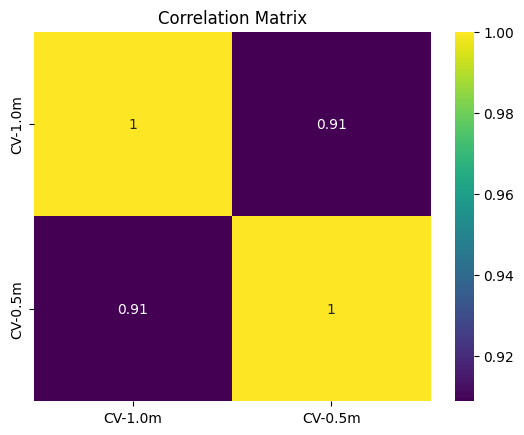

In [10]:
#@title Heatmap of correlation matrix of Selected features
variables = selected_df.columns
locations = df.loc[:,[lat.value, lon.value]].values

#distance_band = DistanceBand.from_array(locations, threshold=20, binary=True, silence_warnings=True)
#knn_weights = KNN.from_array(locations, k=10, silence_warnings=True)

# weights = distance_band

# MBV_mat = Moran_BV_matrix(selected_df, w=weights, varnames=variables)
# Moran_I = np.zeros((selected_df.shape[1], selected_df.shape[1]), dtype=np.float64)

# for (i,j),v in MBV_mat.items():
#     Moran_I[i,j] = v.I
# for i,e in enumerate(selected_df.columns):
#     Moran_I[i,i] = Moran(selected_df[e], weights).I

# Visualize the Moran's I matrix as a heatmap
# sns.heatmap(Moran_I, annot=True, xticklabels=variables, yticklabels=variables, cmap='coolwarm', center=0)
# plt.title("Bivariate Moran's I Matrix")
# plt.show()

sns.heatmap(selected_df.corr(), annot=True, cmap='viridis')  # 'annot' adds numbers on the cells, 'cmap' changes the color map
plt.title('Correlation Matrix')  # Add a title to the heatmap
plt.show()

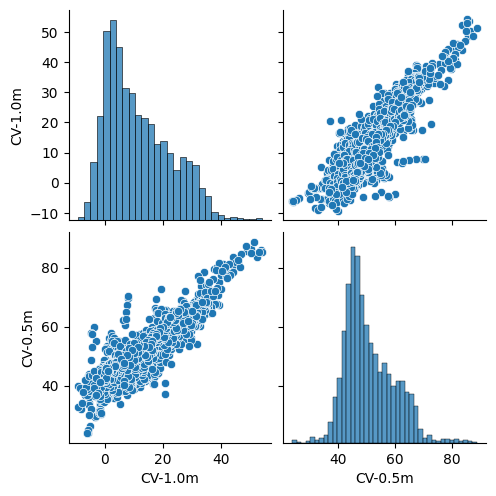

In [11]:
#@title pairplot of corelation matrix of Selected features (optional)
#@markdown this takes a lot of time. you can skip this if you dont want to see the pair plots
sns.pairplot(selected_df)


In [12]:
# @title select number of principal components to keep:
scaler = {
    'RobustScaler'     : RobustScaler(),
    'StandardScaler'   : StandardScaler(),
    'PowerTransformer' : PowerTransformer()
    }[scalar_scheme.value]

X_scaled = scaler.fit_transform(selected_df.values)

# Apply PCA
pca = PCA(n_components=X_scaled.shape[1])
X_pca = pca.fit_transform(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
cdf = pd.DataFrame(np.multiply(cumulative_variance, 100).round(3).reshape(1,-1).tolist(), columns=list(range(1,len(cumulative_variance)+1)), index=["% cumulative variance captured :"])

print("number of Principal Components:")
display(cdf)
print('\n\n')
pca_selector = widgets.IntSlider(
    value=2,
    min=1,
    max=len(cumulative_variance),
    step=1,
    description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
display(pca_selector)

number of Principal Components:


,1,2
% cumulative variance captured :,95.443,100.0


IntSlider(value=2, continuous_update=False, max=2, min=1)

In [13]:
# @title Select threshold to filter out the values
def IQR_outliers(PCs, _threshold):
    """
    Filters out rows from the input array `PCs` that contain outliers.

    Parameters:
    - PCs: A 2D numpy array where each row represents a sample and each column represents a feature.
    - _threshold: A multiplier for the IQR to determine outlier bounds. Default is 1.5.

    Returns:
    - A boolean array where True indicates rows that are within the outlier bounds.
    """
    # Calculate Q1 and Q3 for each feature
    Q1, Q3 = np.percentile(PCs, [25, 75], axis=0)

    # Calculate the IQR for each feature
    IQR = Q3 - Q1

    # Determine lower and upper bounds for outliers
    lower_bounds = (Q1 - _threshold * IQR).reshape(1, -1)
    upper_bounds = (Q3 + _threshold * IQR).reshape(1, -1)

    # Determine which rows are within the bounds
    within_bounds = (PCs >= lower_bounds) & (PCs <= upper_bounds)

    # Return a boolean array where True means the row is within bounds
    return np.all(within_bounds, axis=1)


def mahalanobis_outliers(PCs, confidence_level):
    """
    Detects outliers in the input array `PCs` using the Mahalanobis distance.

    Parameters:
    - PCs: A 2D numpy array where each row represents a sample and each column represents a feature.
    - confidence_level: The confidence level for the chi-squared distribution to determine the outlier threshold.

    Returns:
    - A boolean array where True indicates rows that are considered outliers.
    """
    # Calculate the degrees of freedom (number of features)
    df = PCs.shape[1]

    # Calculate the threshold based on the chi-squared distribution
    threshold_pca = chi2.ppf(confidence_level, df=df)

    # Calculate the covariance matrix and its inverse
    cov_matrix = np.cov(PCs, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Calculate the mean of the data
    mean_PCs = np.mean(PCs, axis=0)

    # Calculate Mahalanobis distances for all samples in one step
    # m_distances = [mahalanobis(x, mean_PCs, inv_cov_matrix) for x in PCs]
    # faster way by vectorizing
    centered_PCs = PCs - mean_PCs
    m_distances = np.sqrt(np.sum(centered_PCs @ inv_cov_matrix * centered_PCs, axis=1))

    # Return a boolean array where True means the Mahalanobis distance exceeds the threshold
    return m_distances <= threshold_pca

def elliptic_envelope_outliers(PCs, contamination_rate):
    """
    Detects outliers in the input array `PCs` using the Elliptic Envelope method.

    Parameters:
    - PCs: A 2D numpy array where each row represents a sample and each column represents a feature.
    - contamination_rate: The proportion of outliers in the data. Default is 0.1.

    Returns:
    - A boolean array where True indicates rows that are not considered outliers.
    """
    # Initialize the EllipticEnvelope model with the specified contamination rate
    elliptic_envelope_pca = EllipticEnvelope(contamination=contamination_rate)

    # Fit the model to the data and predict outliers
    y_pred_pca = elliptic_envelope_pca.fit_predict(PCs)

    # Return a boolean array where True means the row is not an outlier
    return y_pred_pca != -1


whitten = widgets.IntSlider(value=5,
                            min=0, max=100, step=1,
                            description='Scaling factor (%) :',
                            disabled=False,
                            continuous_update=False,
                            orientation='horizontal',
                            readout=True,
                            readout_format='.1f',
                            style={'description_width': 'initial'}
                            )
threshold = widgets.FloatSlider(value=1.2,
                                min=0, max=2, step=0.1,
                                description='Outlier threshold :',
                                disabled=False, continuous_update=False,
                                orientation='horizontal',
                                readout=True, readout_format='.1f',
                                style={'description_width': 'initial'}
                                )
sampling = widgets.SelectionSlider(options=[10],
                                   value=10,
                                   description='No of design points: ',
                                   disabled=False, continuous_update=False,
                                   orientation='horizontal',
                                   readout=True,
                                   style={'description_width': 'initial'}
                                   )
lines_select = widgets.SelectMultiple(options=['All Points', 'Outliers', 'Selected Points', 'Target Points', 'given preffered points', 'Shortlisted Points'],
                                      value=['All Points', 'Outliers', 'Selected Points', 'Target Points', 'given preffered points', 'Shortlisted Points'],
                                      description='Plots: select multiple by holding down ctrl/cmd + click\n',
                                      disabled=False,
                                      style={'description_width': 'initial'},
                                      layout={'width': 'max-content'}
                                      )
outlier_algo = widgets.RadioButtons(options=['IQR Thresholding', 'Mahalanobis Distance', 'Elliptic Envelope'],
                                    value='Elliptic Envelope',
                                    layout={'width': 'max-content'},
                                    description='Outlier detection',
                                    disabled=False,
                                    style={'description_width': 'initial'}
                                    )

def generate_design(data, n_samples, whitten=0):
    ccd = ccdesign(2, center=(1,1), alpha='o', face='cci')
    scaled_ccd = np.zeros_like(ccd) # Initialize scaled CCD with the correct shape
    ccd_min, ccd_max = ccd.min(axis=0), ccd.max(axis=0) # Compute scaling parameters
    data_min, data_max = np.percentile(data, [whitten, 100-whitten], axis=0)
    scaled_ccd = (ccd - ccd_min) / (ccd_max - ccd_min) * (data_max - data_min) + data_min # Scale design
    # Extract subsets
    ccd_boxes = scaled_ccd[:4]
    ccd_star = scaled_ccd[5:9]
    support_points = lambda x: np.repeat(scaled_ccd[np.newaxis, 4, :], x, axis=0) # Support points generator
    # Define the designs list with optimized operations
    designs = [
        np.vstack([ccd_boxes, support_points(1)]),
        np.vstack([ccd_star, support_points(1)]),
    ]
    # Additional designs based on manipulation of existing ones
    designs += [designs[1][:2] / 2, designs[1][2:] / 2, designs[0] / 2]
    # Determine the design closest to the target number of samples
    al_list = np.cumsum([len(d) for d in designs])
    k = np.searchsorted(al_list, n_samples)
    # Concatenate the selected designs up to the closest match
    return np.vstack(designs[:k+1]), al_list.tolist()


pca = PCA(n_components=pca_selector.value)
PCs = pca.fit_transform(X_scaled)
rows_to_keep = np.ones(PCs.shape[0], dtype=bool)
filtered_Pcs = PCs[:,:]
preferedPCs = None
filtered_distances = None
filtered_indices = None
Geo_space_XY = None
Var_space_XY = None
epsilion = 1e-7# change this
NNearest_neighbour = 3 # change this

allowed_samples = [5, 10, 12, 15, 20]# change this
sampling.options = allowed_samples
no_of_samples = 10
sampling.value = no_of_samples
design = generate_design(filtered_Pcs, sampling.value , whitten.value)



def plot_onchange(_threshold, sampling, whitten, plots, outlier_technique):
    global design
    global PCs
    global preferedPCs
    global filtered_Pcs
    global filtered_distances
    global filtered_indices
    global no_of_samples
    global rows_to_keep
    global Geo_space_XY
    global Var_space_XY
    global epsilion
    global NNearest_neighbour
    global threshold
    global text_label

    no_of_samples = sampling
    if outlier_technique == 'IQR Thresholding':
        threshold.max=2
        threshold.step=0.1
        threshold.readout_format='.1f'
        text_label.value = 'times IQR'
        rows_to_keep = IQR_outliers(PCs, _threshold)
    elif outlier_technique == 'Mahalanobis Distance':
        if _threshold > 1:
            threshold.value = 1
        threshold.max=1
        threshold.step=0.01
        threshold.readout_format='.2f'
        text_label.value = 'confidence level'
        rows_to_keep = mahalanobis_outliers(PCs, _threshold)
    elif outlier_technique == 'Elliptic Envelope':
        if _threshold > 0.5:
            threshold.value = 0.5
            _threshold = 0.5
        threshold.max=0.5
        threshold.step=0.001
        threshold.readout_format='.3f'
        text_label.value = 'contamination rate'
        rows_to_keep = elliptic_envelope_outliers(PCs, _threshold)

    filtered_Pcs = PCs[rows_to_keep] # Convert filtered_data list to a NumPy array
    outliers_Pcs = PCs[~rows_to_keep] # Convert filtered_data list to a NumPy array
    design, _ = generate_design(filtered_Pcs, no_of_samples, whitten)

    Geo_space_X = df.loc[rows_to_keep, lat.value]
    Geo_space_Y = df.loc[rows_to_keep, lon.value]
    Geo_space_XY = np.array([Geo_space_X, Geo_space_Y]).T
    Var_space_XY = filtered_Pcs
    max_dist = np.max(distance_matrix(Geo_space_XY,
                           Geo_space_XY))
    geo_max = max_dist
    geo_min = 0 + epsilion
    var_max = .25 # change this
    var_min = 0 + epsilion

    # inference target points
    if prefered_lon:
        preferedPCs = []
        kriging_models = [OrdinaryKriging(Geo_space_Y, Geo_space_X, Var_space_XY[:, i], variogram_model='spherical') for i in range(PCs.shape[1])]
        for kriging_model in kriging_models:
            predicted_value, predicted_std = kriging_model.execute('points', prefered_lon, prefered_lat)
            preferedPCs.append(predicted_value.data)
        preferedPCs = np.vstack(preferedPCs).T

    tree = KDTree(Var_space_XY)
    distances, indices = tree.query(design, k=NNearest_neighbour)
    ind_ko = np.unique(indices)

    # Filter based on valid_indices
    valid_indices = distances < var_max
    filtered_distances = [distances[i][valid_i] for i, valid_i in enumerate(valid_indices)]
    filtered_indices = [indices[i][valid_i] for i, valid_i in enumerate(valid_indices)]
    ind_ko = np.unique(indices[valid_indices])
    avg = np.average(distances, axis=1)
    if (np.min(distances, axis=1) > var_max).any():
        print("\x1b[31mError: scaled design does not fit in varibale scale, please refer to graph to fit the design properly \x1b[0m")
    elif (avg > var_max).any():
        print('''\x1b[33mWarning: scaled design is not a good fit in varibale scale,
                 kindly readjust the thresholds and try again for better fit
                 or try using a different scaler to change the distribution \x1b[0m''')

    # finding unique ind across all design points
    assigned_to = {}  # Tracks which design point an index is assigned to
    point_counts = np.zeros(len(design), dtype=int)  # Tracks how many points are assigned to each design point

    for i in range(len(design)):
        for j in range(NNearest_neighbour):
            if not valid_indices[i][j]:
                break
            idx = indices[i][j]
            dist = distances[i][j]
            # Check if the index is already assigned
            if idx in assigned_to:
                # Retrieve previously assigned design point and distance
                prev_i, prev_dist = assigned_to[idx]
                if dist < prev_dist or (dist == prev_dist and point_counts[i] < point_counts[prev_i]):
                    # Update assignment if current design point is closer or equally close but has fewer points
                    point_counts[prev_i] -= 1
                    point_counts[i] += 1
                    assigned_to[idx] = (i, dist)
            else:
                # Assign index to the current design point
                assigned_to[idx] = (i, dist)
                point_counts[i] += 1
    # Construct the final list of assigned indices for each design point
    assigned_indices = [[] for _ in range(len(design))]
    for idx, (i, _) in assigned_to.items():
        assigned_indices[i].append(idx)
    # Optionally, convert each list of indices to a NumPy array
    assigned_indices = [np.array(lst) for lst in assigned_indices]
    filtered_indices = assigned_indices

    plt.clf()
    plt.figure(figsize=(8,10))
    if 'All Points' in plots:
        plt.scatter(PCs[:,0], PCs[:,1], s=10, c="cyan", label='All Points')
    if 'Outliers' in plots:
        plt.scatter(outliers_Pcs[:,0], outliers_Pcs[:,1], s=10, c="blue", label="Outliers")
    if 'Selected Points' in plots:
        plt.scatter(filtered_Pcs[:,0], filtered_Pcs[:,1], s=10, c="yellow", label="Selected Points")
    if 'Target Points' in plots:
        plt.scatter(design[:,0], design[:,1], marker="+", c="black", s=50, label="Target Points")
        radius = .3
        theta = np.linspace(0, 2 * np.pi, 100) # Create an array of angles from 0 to 2pi
        x_coords = design[:, 0, np.newaxis] + radius * np.cos(theta)
        y_coords = design[:, 1, np.newaxis] + radius * np.sin(theta)
        for x, y, ed_indi in zip(x_coords, y_coords, assigned_indices):
            plt.plot(x, y, 'y:' if len(ed_indi) else 'r-')
    if 'given preffered points' in plots and prefered_lon:
        plt.scatter(*preferedPCs.T, c="magenta", s=20, label="given preffered points" )
        # Annotating each point
        for i, (x, y) in enumerate(preferedPCs):
            plt.annotate(prefered_idx[i], (x, y+.06))
    if 'Shortlisted Points' in plots:
        plt.scatter(filtered_Pcs[ind_ko,0], filtered_Pcs[ind_ko,1], s=10, c="green", label="Shortlisted Points")

    plt.title('Variable Space')
    plt.legend()
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.tight_layout()
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    print("Original Data Shape:", PCs.shape)
    print("Filtered Data Shape:", filtered_Pcs.shape)
    print("Percentage of Data Retained:", f"{filtered_Pcs.shape[0]/PCs.shape[0]*100:.2f}%")



# Create a Label widget for the text
text_label = widgets.Label(' times IQR')
hbox = widgets.HBox([threshold, text_label]) # Arrange the slider and the text label horizontally
interactive_plot = widgets.interactive_output(plot_onchange, {'_threshold':threshold, 'whitten': whitten, 'sampling' : sampling, 'plots': lines_select, 'outlier_technique':outlier_algo})
display(outlier_algo, hbox, whitten, sampling, lines_select, interactive_plot)

RadioButtons(description='Outlier detection', index=2, layout=Layout(width='max-content'), options=('IQR Thres…

IntSlider(value=5, continuous_update=False, description='Scaling factor (%) :', readout_format='.1f', style=Sl…

SelectionSlider(continuous_update=False, description='No of design points: ', index=1, options=(5, 10, 12, 15,…

SelectMultiple(description='Plots: select multiple by holding down ctrl/cmd + click\n', index=(0, 1, 2, 3, 4, …

Output()

In [14]:
# @title inferencing Prefered locations
# @markdown - only location inside the threshold circle will be used
# @markdown - run this cell even if you dont have preferred points

mat_dist = distance_matrix(Geo_space_XY,
                           Geo_space_XY)
np.fill_diagonal(mat_dist, np.nan)
geo_max = np.nanmax(mat_dist)
geo_min = np.nanmin(mat_dist) + epsilion
var_max = .4 # change this
var_min = 0 + epsilion

scale_geo = lambda x: (x - geo_min)/(geo_max - geo_min)*3 #scale between 0 ~ 3
scale_var = lambda x: (x - var_min)/(var_max - var_min)*3 #scale between 0 ~ 3

filtered_distances = [distance.cdist([design[i]], Var_space_XY[e], metric='euclidean').flatten() for i,e in enumerate(filtered_indices)]

# now check which point belong to which group or if it belongs to a group at all?? must use? create a symetric point in XY plane? more than 2 axis???

if prefered_lat:
    x = distance_matrix(design, preferedPCs)
    prefered_mask = (x < var_max).any(axis=0)
    _prefered_lat_lon = np.array([prefered_lat, prefered_lon]).T
    Var_space_XY = np.vstack([Var_space_XY, preferedPCs[prefered_mask]])
    Geo_space_XY = np.vstack([Geo_space_XY, _prefered_lat_lon[prefered_mask]])

    kept_prefered_points = x[x < var_max]
    c = 0
    for i,e in tqdm(enumerate((x < var_max).any(axis=1))):
        if e:
            filtered_indices[i] = np.array([len(Var_space_XY)-len(kept_prefered_points)+c])
            filtered_distances[i] =  np.array([kept_prefered_points[c]])
            c+=1


In [15]:
# @title Adjust weight
print("Weight shift towards geo scale (left) or variable space(right)")
Weight = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.05,
    description='W',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    style={'description_width': 'initial'}
)
display(Weight)

Weight shift towards geo scale (left) or variable space(right)


FloatSlider(value=0.5, continuous_update=False, description='W', max=1.0, step=0.05, style=SliderStyle(descrip…

In [ ]:
# @title Algorithm
def iter_combinations(num_combs=np.nan):

    global filtered_distances
    global filtered_indices

    dists = filtered_distances
    idxs = filtered_indices

    total_combs = np.prod([len(row) if len(row) else 1 for row in dists])
    print(f"Total possible combinations are {total_combs}")
    num_combs = int(np.nanmin([num_combs, total_combs]))
    print(f"iterating through {num_combs} of them")


    # Generate unique combinations efficiently
    combinations = set()

    if num_combs < 4600000:
        # Generate all possible combinations systematically
        all_combinations = itertools.product(*[itertools.product(row_dist, row_idx) for row_dist, row_idx in zip(dists, idxs)])
        for comb in tqdm(itertools.islice(all_combinations, num_combs)):
            curr_comb_dist, curr_comb_idx = zip(*comb)
            combinations.add((tuple(curr_comb_dist), tuple(curr_comb_idx)))
        return combinations

    for _ in tqdm(range(num_combs)):
        curr_comb_dist = []
        curr_comb_idx = []
        for row_dist, row_idx in zip(dists, idxs):
            if len(row_dist) > 0:
                chosen = random.choice(list(zip(row_dist, row_idx)))
                curr_comb_dist.append(chosen[0])
                curr_comb_idx.append(chosen[1])
            else:
                curr_comb_dist.append(None)
                curr_comb_idx.append(None)
        combinations.add((tuple(curr_comb_dist), tuple(curr_comb_idx)))

    return combinations

arr = np.array(list(map(lambda x: x[0] + x[1], iter_combinations(num_combs=4600000))))
W = Weight.value
final_score = float('-inf')
threshold = geo_min
final_result = None
features = Var_space_XY.shape[1]

for i in tqdm(arr):
    idx = i[design.shape[0]:].astype(int)
    dist_matrix = distance_matrix(Geo_space_XY[idx],
                                  Geo_space_XY[idx])
    np.fill_diagonal(dist_matrix, np.inf)
    dgmin = np.nanmin(dist_matrix)
    dvmax = i[:design.shape[0]].max()

    dgmin = scale_geo(dgmin)
    dvmax = scale_var(dvmax)

    score = (- W * scale_var(dvmax)) + (1-W) * scale_geo(dgmin)
    if score > final_score:
        final_score = score
        final_result = idx


Total possible combinations are 3188646
iterating through 3188646 of them


0it [00:00, ?it/s]

  0%|          | 0/3188646 [00:00<?, ?it/s]

In [ ]:
# @title Consideration of Moran's I (optional)
# @markdown running this cell will negate the use of above algorithm and run Moran'I optimization critera instead
arr = np.array(list(map(lambda x: x[0] + x[1], iter_combinations(num_combs=4600000))))
W1 = 0.4  # Example weight for dgmin
W2 = 0.3  # Example weight for dvmax
W3 = 0.3  # Example weight for Moran's I
final_score = float('-inf')
final_result = None
features = Var_space_XY.shape[1]

for i in tqdm(arr):
    idx = i[design.shape[0]:].astype(int)
    dist_matrix = distance_matrix(Geo_space_XY[idx], Geo_space_XY[idx])
    np.fill_diagonal(dist_matrix, np.inf)
    dgmin = np.nanmin(dist_matrix)
    dvmax = i[:design.shape[0]].max()

    dgmin = scale_geo(dgmin)
    dvmax = scale_var(dvmax)

    # Calculate Moran's I for spatial spread
    weights = DistanceBand.from_array(Geo_space_XY[idx], threshold=20, binary=True, silence_warnings=True)

    # Ensure weights are valid
    if np.any(np.isnan(weights.sparse.toarray())) or np.any(np.isinf(weights.sparse.toarray())):
        continue  # Skip this iteration if weights are invalid

    mi_values = []
    for j in range(features):
        values = Var_space_XY[idx, j]
        if not np.any(np.isnan(values)) and not np.any(np.isinf(values)):
            mi = Moran(values, weights)
            if not np.isnan(mi.I) and not np.isinf(mi.I):
                mi_values.append(mi.I)

    if mi_values:
        mi = np.max(mi_values)
    else:
        mi = np.inf  # Assign a high value to mi if no valid Moran's I could be calculated

    # Calculate the score
    score = (W1 * dgmin) + (W2 / dvmax) + (W3 / mi)

    if score > final_score:
        final_score = score
        final_result = idx


In [ ]:
# @title boxplot
pc_filtered = filtered_Pcs[:, 0]  # First component of filtered PCs
var_space = filtered_Pcs[final_result][:, 0]  # First component of Var_space_XY

# Plot the boxplot with the two groups of data
plt.boxplot([pc_filtered, var_space])
# plt.scatter(np.ones(len(var_space)), var_space, color='red', label='Mean + X')
# plt.boxplot()
# Label the points
# for i, value in enumerate(var_space):
#     plt.text(1.25 if i%3==0 else 1.5 if i%3==1 else 1.06, value, f'{value:.2f}', fontsize=9, verticalalignment='center')

plt.title('Box Plot of Filtered PCs')
plt.xlabel('Groups')
plt.ylabel('Value')
plt.xticks([1, 2], ['Entire Dataset', 'Final points'])
plt.show()

In [ ]:
  # @title View results
ndf = pd.DataFrame(Geo_space_XY[final_result], columns=[lat.value, lon.value])
ndf['ID'] = Sample_IDx_FID.values[final_result]
cols = [i.description  for i in checkboxes if i.value]

var_inv = pca.inverse_transform(Var_space_XY[final_result])
var_inv = scaler.inverse_transform(var_inv)

for i,e in enumerate(cols):
    ndf[e + " (approx)"] = var_inv[:,i]
    ndf[e] = Var_space_XY[final_result][:,i]

# display(ndf)

plt.clf()
plt.scatter( df[lon.value],df[lat.value],)
plt.scatter(ndf[lon.value], ndf[lat.value])

# Label the points
for i, (_lon, _lat) in enumerate(ndf.loc[:, [lon.value, lat.value]].values):
    plt.text(_lon, _lat, f'{i}', fontsize=9, verticalalignment='center')

plt.title(f'Geo space w = {W}')
plt.legend(["Dataset", "recommended points"], loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Latitude')
plt.ylabel('longitude')
plt.show()

In [ ]:
# @title Variable Space Plot

x_offset = -0.04  # Adjust this value as needed for better spacing
y_offset = 0.04   # Optional: Adjust vertical spacing if desired

plt.scatter(*filtered_Pcs.T, c='lightyellow', label="Dataset")
plt.scatter(*Var_space_XY[final_result].T, c='red', label="Recommended Points")
plt.scatter(design[:,0], design[:,1], marker="+", c="black", s=50, label="Target Points")

# for i, (_lon, _lat) in enumerate(ndf.iloc[:,-2:].values):
#     # plt.text(_lon + x_offset, _lat + y_offset, f'{ndf["ID"].iloc[i]}', fontsize=9, verticalalignment='center', horizontalalignment='right')
#     plt.text(_lon - x_offset, _lat - y_offset, f'{i}', fontsize=9, verticalalignment='center', horizontalalignment='left')


# Set plot title and labels
plt.title(f'Variable Space w = {Weight.value}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a tight layout and move the legend outside the plot
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [ ]:
# @title download results
ndf.to_csv("results.csv", index=None)
files.download("results.csv")